# Imports

In [1]:
# help here: 
#  - https://www.youtube.com/watch?v=nNvPvvuPnGs 
#  - https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

import os
import time
import math
import warnings
from IPython.display import clear_output, HTML

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint
import requests

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

# Configuration

In [2]:
PREVIEW_REVIEW_SIZE = 1000
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True
PREPROCESS_IMAGES = True
EXTRACT_CNN_FEATURES = True
REQUEST_YELP = True

# SAMPLING
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
WORK_PHOTOS_DIR = 'data/work/yelp_photos/'

PREFIX_YELP = 'yelp_academic_dataset_'

YELP_CLIENT_ID = '9YdHyRH4uodO_PVLWQisUA'
YELP_API_KEY = '7n-jw4kngIfHFPULb9NXfFt0iy0RliPO1ksKqJOykdPVbWU6uSipZld_LPm0CKuto3nmmMLZ6U8vvlrG7J8Lbbe_NTbgpVD4MZXmLBozFALZPaKeoZRemAg1Ph9JZXYx'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)

sns.set()
pandarallel.initialize(progress_bar=True, verbose=False)

# Trick for jupyter lab with pyLdaVis
css_str = """<style> 
    .jp-Button path { fill: var(--jp-inverse-layout-color3);}
    .lm-TabBar-tabIcon path { fill: var(--jp-inverse-layout-color3);}
    .jp-icon-warn0 path {fill: var(--jp-inverse-layout-color3);}
    .bp3-button-text path {    fill: var(--jp-inverse-layout-color3);}
    .jp-icon-brand0 path { fill: var(--jp-inverse-layout-color3);}
    text.terms { fill: var(--jp-inverse-layout-color3);}
</style>"""  
display(HTML(css_str))

# Extractions des sujets des reviews

In [3]:
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

## Prévisualiastions des datasets

In [4]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [5]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



business_id                 name              address  \
61   seKihQKpGGnCeLuELRQPSQ           Twin Peaks       6880 E 82nd St   
187  h_qlv6CIXGVurFOhFQ945w          Tim Hortons  17004 111 Avenue NW   
443  7mpYTDb24SywNMRn3yeakQ     The Twisted Tail         509 S 2nd St   
84   eMjnw_7wp-CscyNh6Lu0ZA      AM&PM Locksmith   8540 Bustleton Ave   
649  oSp8B87eQ8droCGiWUERZA  The Moose Music Row      1203 16th Ave S   

             city state postal_code   latitude   longitude  stars  \
61   Indianapolis    IN       46250  39.906295  -86.047463    3.5   
187      Edmonton    AB     T5S 2X1  53.559979 -113.616269    3.5   
443  Philadelphia    PA       19147  39.941877  -75.145199    4.0   
84   Philadelphia    PA       19152  40.072330  -75.048483    4.5   
649     Nashville    TN       37212  36.143122  -86.793510    4.5   

     review_count  is_open                                         attributes  \
61            257        1  {'CoatCheck': 'False', 'Music': '{'dj': False}...   
187             6        1  {'OutdoorSeating': 'False', 'RestaurantsPriceR...   
443           604        1  {'BusinessParking': '{'garage': False, 'street...   
84             58        1  {'ByAppointmentOnly': 'True', 'BusinessAccepts...   
649            51        1  {'GoodForKids': 'False', 'RestaurantsPriceRang...   

                                            categories  \
61   Sports Bars, American (New), American (Traditi...   
187                                 Coffee & Tea, Food   
443  Event Planning & Services, Whiskey Bars, Ameri...   
84    Keys & Locksmiths, Home Services, Local Services   
649       Hair Salons, Massage, Beauty & Spas, Barbers   

                                                 hours  
61   {'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '...  
187  {'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...  
443  {'Monday': '0:0-0:0', 'Tuesday': '16:0-22:0', ...  
84   {'Monday': '6:0-3:0', 'Tuesday': '6:0-3:0', 'W...  
649  {'Monday': '10:30-17:0', 'Tuesday': '10:30-19:...

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



business_id                                               date
554  -FZYb_CFhjOZIVGj1tRB4w  2010-09-14 01:14:27, 2010-09-14 20:58:29, 2010...
773  -NBNpfXO_WlUJFprqDtcSg  2010-01-23 02:06:45, 2010-01-24 01:22:16, 2010...
25   --gJkxbsiSIwsQKbiwm_Ng  2018-12-15 17:03:44, 2019-01-19 17:59:27, 2019...
36   --x_BmZbxzK_nx_GHBaRVw  2011-12-07 18:42:17, 2012-12-10 00:02:00, 2013...
424  -BjXcRcvDqOQ23eUKx6hjg  2010-02-26 20:13:37, 2010-02-28 21:12:44, 2010...

business_id    object
date           object
dtype: object


PREVIEW review



review_id                 user_id             business_id  \
27   z0osLHDvXvzfm57D4DmD2Q  xVKE_HJ2pwUtTdLbL3pnCg  S2Ho8yLxhKAa26pBAm6rxA   
394  _NAJ4K52B44-pXfrg3EylA  q5bEuV2_PMI0yul7DHk5TA  QKFojAIRYfQQzwssuoKjzw   
717  mx_r8EYx8JooAHa63maSBg  zBWSORvlWDmwtcx6627qWQ  gwNlSSV0hGgNgTqPprj4FQ   
773  IZtEteas_Oruk0skO4BaSA  DUgvASMlwPxHKe6LZSmO4w  OHzX-ZD9qyoeoxR8Z0dlIA   
999  HBCwI0ahXuni3x030HGKFA  WKe2b_EeLBnZ3lZV5WKYGQ  -Or44IdY51Ukd618kikmtA   

     stars  useful  funny  cool  \
27       3       0      0     0   
394      5       0      0     0   
717      3       1      0     0   
773      5       0      0     0   
999      4       0      0     0   

                                                  text                date  
27   Service was crappy, and food was mediocre.  I ... 2016-11-22 00:22:53  
394  Another great annual festival Edmonton has to ... 2017-08-29 00:55:57  
717  Monthly lunch with my fellow colleagues the ot... 2013-07-12 20:30:23  
773  Good drinks and food. Had the pulled pork and ... 2015-06-21 04:46:02  
999  My friends and I all got one of each that were... 2016-07-25 06:28:49

review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



user_id             business_id  \
986  vZWNh7DMwYVgz3sz-JudwQ  _oEowuP5v_lKWB7G91_p1Q   
485  SkYIKEIQfEo65_xHNM114w  SCjUeZfjafJ88fWWQjRh2w   
577  -f-WbCGOmScMVk7lLstdhA  wG7L9GFtFD5cu8y_P-z5pg   
489  KDewJBJknfWvQyHHFNbfdg  ipZ7neK1bjBAUrCqyCvB_Q   
840  RIXIoCTafjr1auUJkV3fLg  RSjBOAFBKklF5k3XYEzxjA   

                                                  text                date  \
986                    OMG the green apple is so yummy 2015-06-13 23:54:13   
485  Ask for the super spicy habanero relish on the... 2012-01-05 00:35:18   
577  Skip the line and drop off your packages (prep... 2017-06-23 02:45:11   
489                     Shopping getaway office hours! 2010-12-18 21:09:01   
840             Get here early to find shaded parking. 2014-06-08 20:53:53   

     compliment_count  
986                 0  
485                 0  
577                 0  
489                 0  
840                 0

user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



user_id   name  review_count        yelping_since  useful  \
838  LAwptwS7nJwPkV5Niy9jkg   Jeff           572  2007-11-23 22:22:31    3822   
344  Js4nQlGRjS1Bd5vsAQQfgA    Tom           396  2008-03-31 01:11:13    1289   
302  FVjmJWsjzed0yDGlOB0QqA  Cidne           475  2006-09-15 01:32:26    4190   
439  EROW4chFZQF1E-eZVpYAAA  Aimee            57  2009-02-02 00:08:06      95   
159  ouODopBKF3AqfCkuQEnrDg  Danan          2108  2010-04-09 05:28:01    4527   

     funny  cool                                              elite  \
838   2285  3091  2009,2011,2012,2013,2014,2015,2016,2017,2018,2...   
344    337   681       2009,2010,2011,2012,2013,2014,2015,2016,2017   
302   6294  4522                           2006,2007,2008,2009,2010   
439     33    43                                                      
159   1110  2850  2010,2011,2012,2013,2014,2015,2016,2017,2018,2...   

                                               friends  fans  ...  \
838  DUS7E1bmqBF62iQG8RaRuA, 6XhkfO98cXccFfD7z0CwBA...    55  ...   
344  4YwesZEX8VPPJOKLfPD7lg, 82UbpDEPMGJ9Sod8a1U-cg...    44  ...   
302  eKRZ3GqAARhgU_JoL7kxAQ, sfp6PhgbQnemfeZTqfuajA...   295  ...   
439  8M4_nA8e9VacrirvCwrl8Q, T46BA9GqSKY2BkkKbqamVg...     3  ...   
159  tlEHfYMPIm8-AMMk3T1s0w, aOkQtJvCvGzLUNVtaGb9xQ...   134  ...   

     compliment_more  compliment_profile  compliment_cute  compliment_list  \
838               15                  15                8                6   
344               11                   3                4                5   
302               78                  53              168               15   
439                2                   1                0                0   
159               15                  20               10                1   

     compliment_note  compliment_plain  compliment_cool  compliment_funny  \
838               76               129              235               235   
344               43               113              107               107   
302              560               989             1264              1264   
439                2                 6                6                 6   
159               65                87               89                89   

     compliment_writer  compliment_photos  
838                121                 32  
344                 66                 17  
302                234                100  
439                  4                  0  
159                 92                  6  

[5 rows x 22 columns]

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

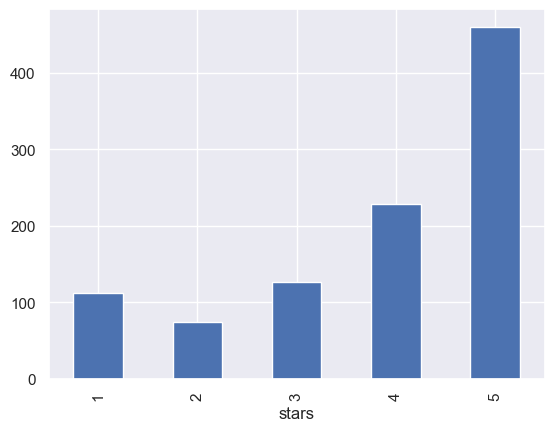

In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [7]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [8]:
review = preview_dfs['review']
for star in range(1,6):
    title = HTML(f'<h3 style="">Note = {star}<br><hr></h3>')
    display(title)
    for index in review[review['stars']==star].sample(2, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        quote = HTML(f'<div style="border-left: 4px solid yellow; padding-left:10px; margin-bottom:20px;">{text}</div>')
        display(quote)

<Axes: xlabel='class'>

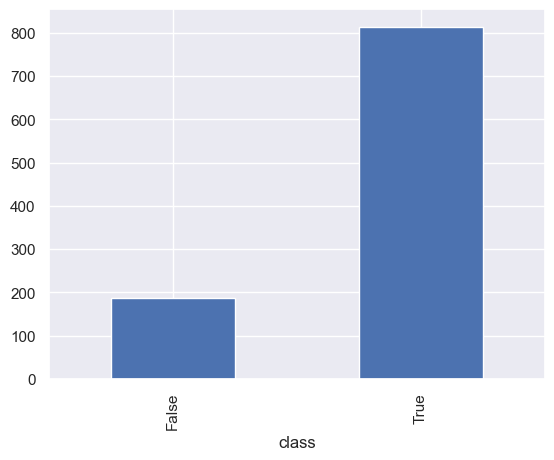

In [9]:
bad_stars = 2
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > bad_stars
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [10]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]
print(f'{sampling_coef_bad*100:.0f}% des reviews ont au maximum {bad_stars} étoiles')

23% des reviews ont au maximum 2 étoiles


## Extraction d'un échantillons de reviews

### Recensement des catégories de business

In [11]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

134964    [Hospitals, Health & Medical, Medical Centers,...
46818     [Ear Nose & Throat, Otologists, Health & Medic...
25369     [American (New), Breakfast & Brunch, Vegetaria...
52095                     [Carpet Cleaning, Local Services]
55353     [Beauty & Spas, Cosmetics & Beauty Supply, Day...
Name: _cats, dtype: object

In [12]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [13]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Restaurants', 'Pop-Up Restaurants', 'Restaurant Supplies']

In [14]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Food Stands',
 'Food Trucks',
 'Specialty Food',
 'Seafood Markets',
 'Food Tours',
 'Food Court',
 'Ethnic Food',
 'Live/Raw Food',
 'Food Banks',
 'Comfort Food',
 'Seafood',
 'Food Delivery Services',
 'Fast Food',
 'Do-It-Yourself Food',
 'Imported Food',
 'Soul Food',
 'Food']

### Création des fichiers parquets

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité

In [15]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


In [16]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [17]:
print(f'Exemple de dataFrame contenant les enregistrements qui ont au maximum {bad_stars} étoiles')
get_reviews(max_stars=bad_stars).sample(5)

Exemple de dataFrame contenant les enregistrements qui ont au maximum 2 étoiles


review_id                 user_id             business_id  \
index                                                                           
7517   NqwIX1HwiBT_6pd0nRnSwg  vgXCPv4SDZ30SPzWBbGO_g  yeHLiKNp0hyR-ig4M6us-w   
4054   u1zDs4Zkn4uq4MPXPH7Olw  W9FB3uOg-bOI6KXL2vDIWw  KZe5kpIHWVuJl6WgNYzceg   
10470  6zH_fu8M5ERn9N1h6oMc7g  xAP2xtc6VWKyvcQD4Mgk1g  AM7gPGpRbEjEkjmsmQXb6w   
3829   3JY3kSJwD0yXZ4LG9S7Ccg  jo4dzlj8y003efCpPPT4zQ  g04aAvgol7IW8buqSbT4xA   
12310  -gpfmt1SyZvFDjWb5IXfEA  bsxHpxxT7UwtLcRl9UntAg  1IjHo5kaSdFxJkJotU4O7A   

       stars  useful  funny  cool  \
index                               
7517       1       0      0     0   
4054       1       2      2     1   
10470      2       0      0     0   
3829       2       0      0     0   
12310      2       4      2     0   

                                                    text                date  \
index                                                                          
7517   After a 90-min wait (we were told it would be ... 2016-12-30 22:58:10   
4054   If I could give zero stars I would.  Service w... 2014-04-02 03:05:02   
10470  Not what I was expecting, very disappointing! ... 2017-01-15 00:19:51   
3829   Server was not good, I had high expectations o... 2018-07-07 22:34:02   
12310  I'm giving this review for a few VERY specific... 2018-08-20 15:59:28   

                                    name  ...   latitude  longitude  \
index                                     ...                         
7517               Livery - Indianapolis  ...  39.776681 -86.145663   
4054                 Please-U-Restaurant  ...  29.936738 -90.077631   
10470            Restaurant des Familles  ...  29.778169 -90.098591   
3829                   Cafe Fleur De Lis  ...  29.954494 -90.066592   
12310  Sociale Italian Tapas & Pizza Bar  ...  27.884430 -82.486270   

      stars_business review_count  is_open  \
index                                        
7517             4.5          971        1   
4054             4.0          274        1   
10470            4.0          167        1   
3829             4.0         1865        1   
12310            4.0          125        0   

                                              attributes  \
index                                                      
7517   b'{"DogsAllowed":"False","RestaurantsTableServ...   
4054   b'{"RestaurantsReservations":"True","Restauran...   
10470  b'{"RestaurantsReservations":"True","BusinessA...   
3829   b'{"RestaurantsReservations":"False","Alcohol"...   
12310  b'{"ByAppointmentOnly":"False","HappyHour":"Tr...   

                                              categories  \
index                                                      
7517   Food, American (New), Nightlife, Bars, Empanad...   
4054   Cajun/Creole, Breakfast & Brunch, Diners, Rest...   
10470                 Cajun/Creole, Seafood, Restaurants   
3829   Breakfast & Brunch, Coffee & Tea, Food, Restau...   
12310  Restaurants, Cocktail Bars, Italian, Nightlife...   

                                                   hours  \
index                                                      
7517   b'{"Monday":"0:0-0:0","Tuesday":"16:0-22:0","W...   
4054   b'{"Monday":"0:0-0:0","Tuesday":"7:0-15:0","We...   
10470  b'{"Monday":"11:30-21:0","Tuesday":"11:30-21:0...   
3829   b'{"Monday":"7:0-13:0","Tuesday":"7:0-13:0","W...   
12310  b'{"Monday":"16:0-21:0","Tuesday":"16:0-21:0",...   

                                                   _cats review_count_q  
index                                                                    
7517   b'["Food","American (New)","Nightlife","Bars",...             c4  
4054   b'["Cajun/Creole","Breakfast & Brunch","Diners...             c4  
10470        b'["Cajun/Creole","Seafood","Restaurants"]'             c4  
3829   b'["Breakfast & Brunch","Coffee & Tea","Food",...             c4  
12310  b'["Restaurants","Cocktail Bars","Italian","Ni...             c4  

[5 rows x 24 columns]

## Analyse des echantillons de reviews 

### Fonctions de traitement du text

In [18]:
def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def extract_n_grams(token_list, n_list):
    import nltk
    n_grams = []
    for n in n_list:
        n_grams.append([' '.join(n_gram) for n_gram in nltk.ngrams(token_list,n)])

    new_token_list = []
    for n_gram in n_grams:
        new_token_list  = new_token_list + n_gram

    if 1 in n_list:
        new_token_list = token_list + new_token_list

    return new_token_list    
    
def display_word_cloud(reviews, no_below = 4, no_above = 0.1, max_words_in_cloud=50, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)

    stop_words = get_negative_sw()
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    # Sampling for word cloud
    cloud_sample_size = min(reviews.shape[0], 1000)
    sample = reviews.sample(cloud_sample_size, random_state=0)['tokens']

    # Filter extremes filter
    dictionary = corpora.Dictionary(list(sample))
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    sample.parallel_apply(lambda tokens: [token for token in tokens if token in list(dictionary.values())])
    
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')

    # Join text and display wordcloud
    sample_text = ' '.join(sample.str.join(' ').values)
    wordcloud = WordCloud(background_color = 'white', max_words = max_words_in_cloud).generate(sample_text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();
    print('')

### Nuages de mots par note

Note = 5


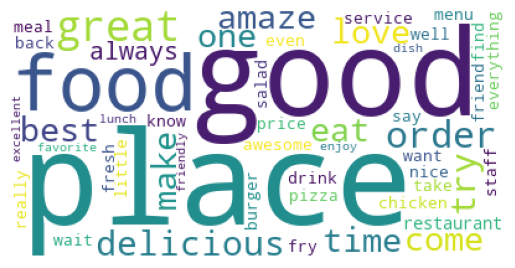


Note = 4


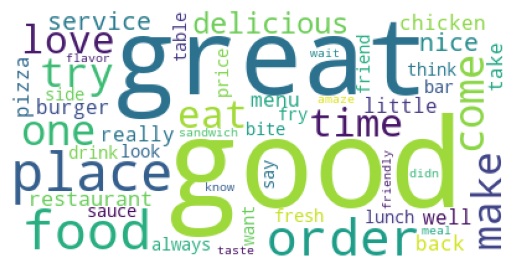


Note = 3


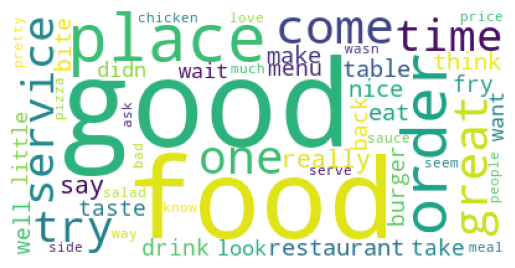


Note = 2


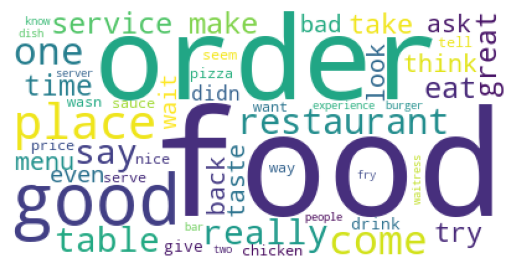


Note = 1


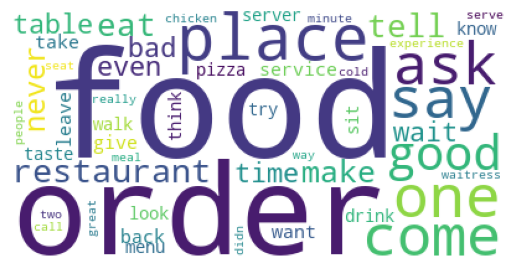

In [19]:
for stars in range(5,0,-1):
    print(f'Note = {stars}')
    display_word_cloud(reviews=get_reviews(stars=stars),
                       no_below=2,
                       no_above= 0.1, 
                       max_words_in_cloud=50)

## Recherche des sujets d'insatisfactions

### Sac de mots (TF-IDF)

In [20]:
def tf_idf(reviews, min_df = 4, max_df = 100, ngram_range=(1,2), verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

    return values, vectorizer.get_feature_names_out()

In [21]:
print(f'Vectorisation pour les reviews comportant maximum {bad_stars} étoiles')
reviews = get_reviews(max_stars=bad_stars)
values, features_names = tf_idf(reviews=reviews,
                                min_df=10,
                                max_df=0.1,
                                ngram_range=(1,2),
                                verbose=1)

Vectorisation pour les reviews comportant maximum 2 étoiles
Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


100  1st  2nd  able  absolute  absolutely  accept  accommodate  \
0  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
1  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
2  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
3  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
4  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   

   acknowledge  across  ...  yelp       yes  yesterday  yet  york  young  \
0          0.0     0.0  ...   0.0  0.231769        0.0  0.0   0.0    0.0   
1          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
2          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
3          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
4          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   

   yuck  yummy      zero  zero star  
0   0.0    0.0  0.000000        0.0  
1   0.0    0.0  0.000000        0.0  
2   0.0    0.0  0.176228        0.0  
3   0.0    0.0  0.000000        0.0  
4   0.0    0.0  0.000000        0.0  

[5 rows x 1901 columns]

+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.2965           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | anyone: 0.2395           |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | attention: 0.2499        |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | cash: 0.2758             |
|                                                                           

### LDA Librairie Sklean

In [22]:
def get_topics(reviews: pd.DataFrame, min_df = 4, max_df = 10, n_topics = 10, alpha = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)
    
    if verbose > 1: print('  - Vectorisation (tf-idf)')
    values, features_names = tf_idf(reviews=reviews, min_df=min_df, max_df=max_df, ngram_range=ngram_range, verbose = 0)

    # Topics from LDA or MDF
    if verbose > 1: print('  - Modélisation LDA')
    model = LatentDirichletAllocation(n_components=n_topics,
                                      max_iter=10,
                                      doc_topic_prior=alpha,
                                      learning_method='online', 
                                      learning_offset=10,
                                      random_state=0,
                                      n_jobs=-1)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        features = [features_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)

    return topics

In [23]:
params = {
    'max_stars': bad_stars,
    'min_df': 2,
    'max_df': 0.1,
    'n_topics': 5,
    'alpha': 0.5,
    'n_top_words': 5,
    'ngram_range': (1,1)
}

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.1
n_topics     5
alpha        0.5
n_top_words  5
ngram_range  (1, 1)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  --------------------------------------------
         0  pizza, waitress, burger, sauce, bar
         1  mahi, gun, trio, uncooked, surly
         2  bueno, wifi, liver, fancy, performance
         3  refer, 312, tony, denny, angelo
         4  initially, expense, goopy, preference, legit


In [24]:
params['alpha'] = 0.2
params['max_df'] = 0.2
params['ngram_range'] = (3,3)

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.2
n_topics     5
alpha        0.2
n_top_words  5
ngram_range  (3, 3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ------------------------------------------------------------------------------------------
         0  would not recommend, food good not, not recommend place, not impress food, could give zero
         1  waste time money, not worth price, food mediocre best, make feel like, get order wrong
         2  food nothing special, get money back, happy hour menu, nothing write home, take one bite
         3  take minute get, not worth wait, never come back, would give star, take drink order
         4  not very good, want like place, give two star, really want like, service very slow


### LDA Librairie Gensim et optimisation du nombre de sujets

In [25]:
def prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1):
    print('  - Préparation des data (preprocess tokenisation...)')

    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=False, verbose=False)
    
    # Preprocess, tokenize and drop stop words
    reviews = get_reviews(max_stars=max_stars)
    texts = reviews['text'].parallel_apply(preprocess_text)
    texts = texts.parallel_apply(tokenize)
    stop_words = get_negative_sw()
    texts = texts.parallel_apply(drop_words, args=(stop_words,))
    
    # Managing n_grams
    texts = texts.parallel_apply(extract_n_grams, args=(n_grams,))

    # list texts
    texts = list(texts)
    
    # create document terms matrix
    dictionary = corpora.Dictionary(texts)
    
    #filter extremes
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in texts]

    return texts, dictionary, corpus

def modelize(dictionary, corpus, alpha = 10, num_topics = 10):
    print(f'  - LDA pour {num_topics} topics')
    LDA = gensim.models.ldamodel.LdaModel
    model = LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, random_state=0, chunksize=1000, passes=50,iterations=100)
    return model

def visualize_model(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis

def print_topics(model):
    topics = []
    for topic in model.show_topics():
        index = topic[0] + 1
        terms = '\n'.join(topic[1].split(' + '))
        topics.append([index, terms])
    
    print(tabulate(topics, headers=['Topic n°', 'mots clés'], tablefmt="grid"))

In [26]:
texts, dictionary, corpus = prepare_data(max_stars=2, n_grams=[2,3], no_below=2, no_above=0.2)
model = modelize(dictionary=dictionary, corpus=corpus, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+--------------------------+
|   Topic n° | mots clés                |
+============+==========================+
|          1 | 0.005*"come back"        |
|            | 0.004*"taste like"       |
|            | 0.003*"win back"         |
|            | 0.002*"food not"         |
|            | 0.002*"wait staff"       |
|            | 0.002*"felt like"        |
|            | 0.002*"every time"       |
|            | 0.002*"mac cheese"       |
|            | 0.002*"fast food"        |
|            | 0.002*"mexican food"     |
+------------+--------------------------+
|          2 | 0.004*"look like"        |
|            | 0.003*"not return"       |
|            | 0.003*"even though"      |
|            | 0.002*"not sure"         |
|            | 0.002*"good place"       |
|            | 0.002*"good thing"       |
|            | 0.002*"mash potato"      |
|            | 0.002*"like place"       |


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.148313 -0.097004       1        1  20.580605
0     -0.042846  0.052658       2        1  20.199007
4      0.112619  0.179830       3        1  19.898488
1      0.174357 -0.167909       4        1  19.864926
3     -0.095816  0.032426       5        1  19.456974, topic_info=            Term       Freq       Total Category  logprob  loglift
703    last time  36.000000   36.000000  Default  30.0000  30.0000
139   first time  67.000000   67.000000  Default  29.0000  29.0000
2046  last night  36.000000   36.000000  Default  28.0000  28.0000
97    taste like  95.000000   95.000000  Default  27.0000  27.0000
335    look like  56.000000   56.000000  Default  26.0000  26.0000
...          ...        ...         ...      ...      ...      ...
169     food not  17.790630   52.310808   Topic5  -6.3650   0.5584
71      get food  17.468355   61.615338   Topic5  -6.3833   0.3764
112    didn even  16.063520   43.468071   Topic5  -6.4671   0.6415
63     come back  17.554215  121.905544   Topic5  -6.3784  -0.3010
175     not even  14.987777   48.038694   Topic5  -6.5364   0.4722

[328 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1800      5  0.931457    almost hour
1546      1  0.905917  almost minute
4231      2  0.975568    another try
3677      5  0.918649      ask order
2721      1  0.907344     ask waiter
...     ...       ...            ...
1037      2  0.019768      would not
1037      4  0.019768      would not
1037      5  0.652330      would not
3038      3  0.073455    would think
3038      4  0.881458    would think

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

In [27]:
texts, dictionary, corpus = prepare_data(max_stars=1, n_grams=[3], no_below=2, no_above=0.1)
model = modelize(dictionary=dictionary, corpus=corpus, alpha=20, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+-----------------------------------+
|   Topic n° | mots clés                         |
+============+===================================+
|          1 | 0.012*"waste time money"          |
|            | 0.011*"never come back"           |
|            | 0.009*"get money back"            |
|            | 0.009*"buy one get"               |
|            | 0.008*"could give zero"           |
|            | 0.008*"would not recommend"       |
|            | 0.008*"take drink order"          |
|            | 0.007*"excite try place"          |
|            | 0.007*"give another chance"       |
|            | 0.007*"come back check"           |
+------------+-----------------------------------+
|          2 | 0.009*"want like place"           |
|            | 0.009*"make eye contact"          |
|            | 0.008*"wish could give"           |
|            | 0.008*"say didn know"             |
|     

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.108142  0.122379       1        1  20.038914
0     -0.090220  0.020157       2        1  20.034222
3      0.078216 -0.038631       3        1  19.990335
4      0.023514 -0.145471       4        1  19.976336
2     -0.119652  0.041566       5        1  19.960192, topic_info=                   Term      Freq      Total Category  logprob  loglift
196      new york pizza  4.000000   4.000000  Default  30.0000  30.0000
385         buy one get  4.000000   4.000000  Default  29.0000  29.0000
570    make eye contact  4.000000   4.000000  Default  28.0000  28.0000
225       take one bite  4.000000   4.000000  Default  27.0000  27.0000
83       get money back  4.000000   4.000000  Default  26.0000  26.0000
..                  ...       ...        ...      ...      ...      ...
214       give one star  1.885274   4.959254   Topic5  -5.3609   0.6442
205      taste like old  1.644798   3.553527   Topic5  -5.4973   0.8411
63      never come back  1.876602  12.071960   Topic5  -5.3655  -0.2500
703  food great service  1.589959   2.839388   Topic5  -5.5312   1.0316
281    call place order  1.572933   2.843788   Topic5  -5.5420   1.0192

[259 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
510       5  0.938971   actually get eat
147       2  0.939829  almost hour drink
71        2  0.939824       ask girl add
182       1  0.176013  ask speak manager
182       3  0.352026  ask speak manager
...     ...       ...                ...
542       3  0.701632   wouldn come back
115       4  0.938681   write bad review
195       2  0.200893    zero star would
195       3  0.200893    zero star would
195       4  0.602678    zero star would

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

# Classifications des images

## Prévisualisation du dataset

In [28]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

photo_id             business_id  \
116571  duYtVRha1usf6q9NiUGdPw  KcctvgRdN15o8ciZ_w01qA   
194701  j8FNAYg3gLi037GpqOfmKg  VVJGaIudj4Ffdvm8OdX2Mg   
47240   VjOqGni3aKFrR5piBuVegQ  x8AQIEjSqsW0z4vRyBetbw   
53529   RYXjG4w-TfDRWsboHK50Mw  p1R63C5BpV2rOurtC4fgdg   
139924  aeT9Tp7Uq5ycnBzUWVCb-A  JSnNc1WIH37vfYFgVBOu7g   

                                                  caption   label  
116571                                                       food  
194701                                         Strawberry    food  
47240                                                        food  
53529                                                        food  
139924  Experience single origin the way the pour over...  inside

In [29]:
df_photos.shape

(200100, 4)

In [30]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## Creation dataset echantillons

L'échantillon contient 500 images


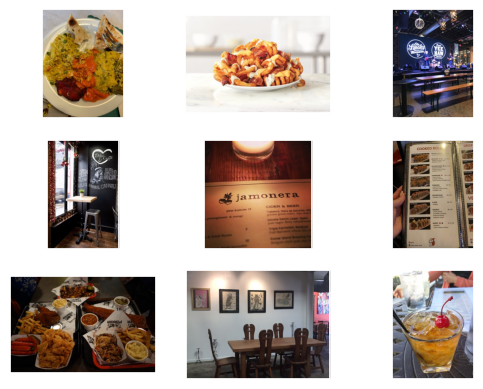

In [31]:
def get_original_photo_path(photo_id):
    return ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg'
    
photo_ids = {}
df_photos_sampling = pd.DataFrame()
for label in df_photos.label.unique():
    photo_ids = list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])
    df_label = pd.DataFrame({
        'photo_id': photo_ids,
        'label': np.full(len(photo_ids), label),
        'width': np.zeros(len(photo_ids)), 
        'height': np.zeros(len(photo_ids)), 
        'mode': np.full(len(photo_ids), '')
    })
    df_photos_sampling = pd.concat([df_photos_sampling, df_label], ignore_index=True)

label_encoder = LabelEncoder()
df_photos_sampling['label_num'] = label_encoder.fit_transform(df_photos_sampling['label'])

print(f'L\'échantillon contient {df_photos_sampling.shape[0]} images')

sample_ids = list(df_photos_sampling.sample(9, random_state=1)['photo_id'])
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = matplotlib.image.imread(get_original_photo_path(sample_ids[i]))
    plt.imshow(image)
    plt.grid(linewidth=0)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()

In [32]:
def fill_infos(df):
    for index in df.index:
        print(f'Lecture infos image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        img = Image.open(get_original_photo_path(photo_id))
        
        w, h = img.size
        df.loc[df['photo_id']==photo_id, 'height'] = h   
        df.loc[df['photo_id']==photo_id, 'width'] = w
        df.loc[df['photo_id']==photo_id, 'mode'] = img.mode

fill_infos(df_photos_sampling)
df_photos_sampling.sample(5)

photo_id    label  width  height mode  label_num
358  cW5lOsgYDpxIpeprGPXv9A     food  300.0   400.0  RGB          1
486  npwOFduWqbV82Au4kAosDg     menu  309.0   400.0  RGB          3
166  lhAjL7H5xuynga18TcPReA  outside  300.0   400.0  RGB          4
240  WWKvN7U_er2nrM3o6GUrMA    drink  455.0   400.0  RGB          0
247  KxnqdlCS1WNnvQeTT051WQ    drink  279.0   400.0  RGB          0

In [33]:
df_photos_sampling.describe()

width      height  label_num
count  500.000000  500.000000  500.00000
mean   438.882000  389.688000    2.00000
std    131.985303   32.814085    1.41563
min    131.000000   69.000000    0.00000
25%    300.000000  400.000000    1.00000
50%    408.000000  400.000000    2.00000
75%    543.750000  400.000000    3.00000
max    600.000000  400.000000    4.00000

In [34]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64

## Clustering par descripteurs SIFT

In [35]:
df_sift = df_photos_sampling.copy()

### Pretraitement des images

In [36]:
def preprocess_images_sift(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_sift(photo_id)

def preprocess_image_sift(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        img = histo_rgb(img)
    else:
        img = Image.open(original_path)
    
    img = treat_histogram(img)
    img = filter_img(img)
    new_path = save_img(current_path=original_path, img=img, work_part='sift')

    if display_evo:
        img = display_img(new_path)
        img = histo_rgb(img)
    
    return new_path
    
def display_img(path):
    img = Image.open(path)
    display(img)
    return img

def histo_rgb(img):
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

    return img

def treat_histogram(img):
    # Equalize and autocontrast
    img = ImageOps.equalize(img)
    img = ImageOps.autocontrast(img)
    return img
    

def filter_img(img):
    # Apply gaussian blur
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img

def save_img(current_path, img, work_part):
    filename = os.path.basename(current_path)
    new_path = WORK_PHOTOS_DIR + work_part + '/' + filename
    img.save(new_path)

    return new_path

#### Exemple de pre-traitement

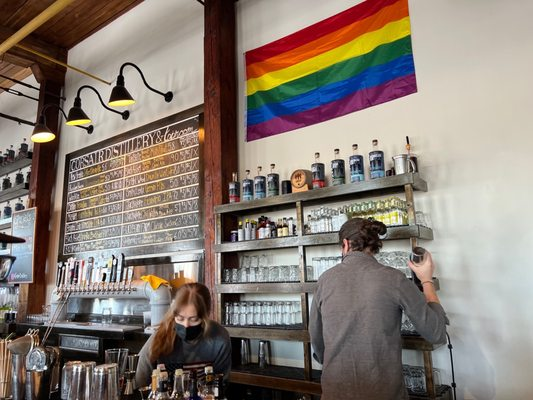

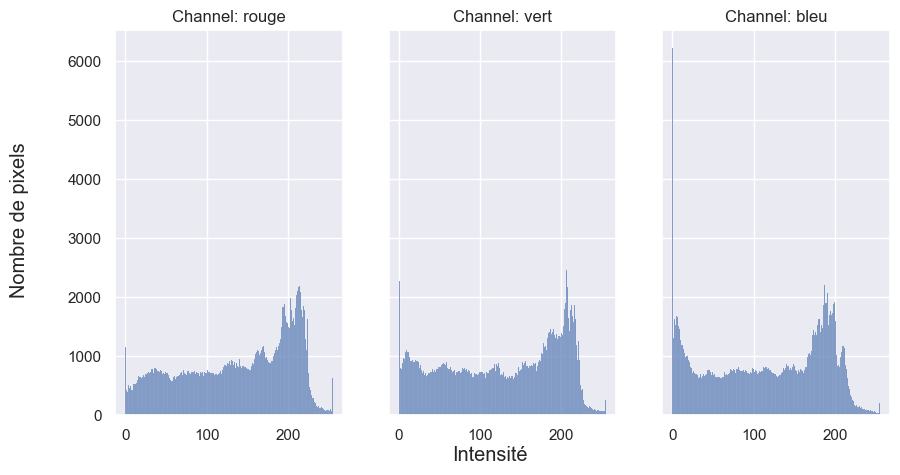

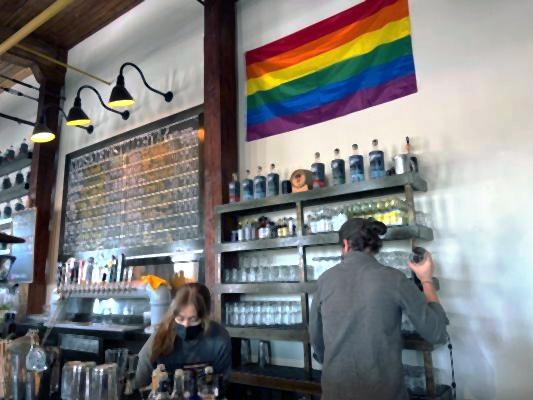

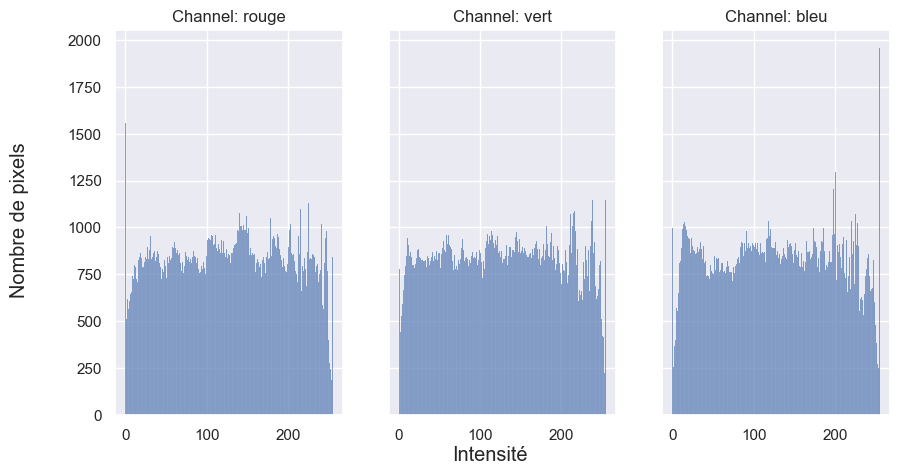

'data/work/yelp_photos/sift/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [37]:
photo_id_sample = df_sift.sample(1, random_state=0)['photo_id'].iloc[0]
preprocess_image_sift(photo_id_sample,display_evo=True)

#### Pretaitement de l'ensemble de l'échantillon

In [38]:
if PREPROCESS_IMAGES:
    preprocess_images_sift(df=df_sift)

### Creation des descripteurs

In [39]:
def get_descripteurs(photo_id, max_desc=500, work_dir = WORK_PHOTOS_DIR, plot = False, print_desc = False):
    import cv2
    sift = cv2.xfeatures2d.SIFT_create(max_desc)
    image = cv2.imread(work_dir + 'sift/' + photo_id + '.jpg')
    kp, desc = sift.detectAndCompute(image, None)

    if plot:
        img=cv2.drawKeypoints(image,kp,image)
        plt.imshow(img)
        plt.grid(linewidth=0)
        plt.show()

    if print_desc:
        print("Descripteurs : ", desc.shape)
        print()
        print(desc)
    
    return desc    

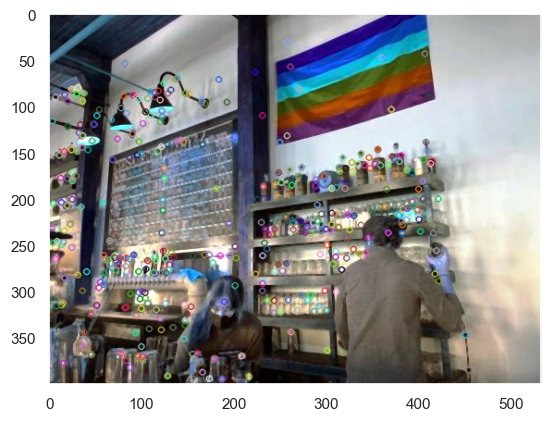

Descripteurs :  (501, 128)

[[ 0.  0.  0. ...  1. 18. 18.]
 [13. 14.  8. ... 24.  0.  1.]
 [24.  0.  0. ...  2.  5. 25.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [ 0.  0.  0. ...  0.  2. 13.]
 [ 0.  0. 10. ...  0.  0. 12.]]


In [40]:
desc = get_descripteurs(photo_id=photo_id_sample, plot=True, print_desc=True)

In [41]:
pandarallel.initialize(progress_bar=True, verbose=False)
descripteurs = df_sift['photo_id'].parallel_apply(get_descripteurs, args=(500,))
df_sift['desc'] = descripteurs
display(df_sift.sample(3))
num_img_desc = df_sift['desc'][0].shape[0]

photo_id   label  width  height mode  label_num  \
46   _Na9wfTMObz6Cdc2Mr3uUg  inside  600.0   400.0  RGB          2   
381  m_uoH5zddSVoooEdkOvUqA    food  300.0   400.0  RGB          1   
399  OhSQCZYzh904IDltim9riw    food  533.0   400.0  RGB          1   

                                                  desc  
46   [[2.0, 0.0, 6.0, 19.0, 0.0, 0.0, 9.0, 46.0, 5....  
381  [[5.0, 40.0, 46.0, 20.0, 18.0, 6.0, 1.0, 2.0, ...  
399  [[9.0, 33.0, 99.0, 43.0, 13.0, 5.0, 0.0, 0.0, ...

### Clustering des descripteurs

In [42]:
all_descripteurs = np.concatenate(df_sift['desc'].values, axis=0)
n_clusters = math.floor(math.sqrt(len(all_descripteurs)))
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=512, random_state=0, n_init="auto").fit(all_descripteurs)
print(f'Il y a {n_clusters} clusteurs pour un total de {len(all_descripteurs)} descripteurs')

Il y a 494 clusteurs pour un total de 244742 descripteurs


### Creations des features des images

In [43]:
def features_sift(descripteurs, kmeans: MiniBatchKMeans):
    import numpy as np
    desc_clusters = kmeans.predict(descripteurs)
    return np.histogram(desc_clusters, bins=kmeans.n_clusters, range=(0, kmeans.n_clusters))[0]

features = df_sift['desc'].parallel_apply(features_sift, args=(kmeans,))
df_sift['features'] = features
df_sift.sample(3)

photo_id    label  width  height mode  label_num  \
74   0_7vvAY53InVrG2QqBGZ1w   inside  600.0   400.0  RGB          2   
51   Gl7iExBEXudvs5zkPfmoCA   inside  300.0   400.0  RGB          2   
169  r-z2praQ2b7CRIAzWgl9qQ  outside  598.0   400.0  RGB          4   

                                                  desc  \
74   [[2.0, 7.0, 14.0, 1.0, 3.0, 16.0, 52.0, 15.0, ...   
51   [[0.0, 14.0, 38.0, 15.0, 1.0, 3.0, 4.0, 0.0, 0...   
169  [[6.0, 9.0, 4.0, 17.0, 63.0, 2.0, 0.0, 2.0, 13...   

                                              features  
74   [3, 2, 0, 0, 1, 0, 0, 1, 6, 0, 2, 0, 2, 2, 0, ...  
51   [1, 0, 0, 1, 0, 0, 1, 0, 0, 3, 0, 0, 2, 0, 1, ...  
169  [2, 0, 1, 0, 0, 0, 0, 1, 1, 4, 1, 0, 1, 2, 0, ...

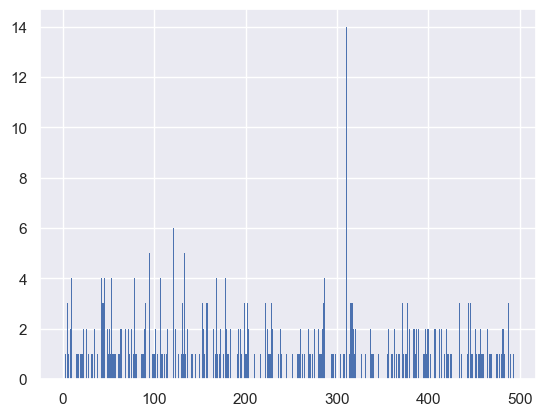

In [44]:
features_sample = df_sift['features'][0]
plt.bar(range(len(features_sample)), features_sample, linewidth=0)
plt.show()

### Reduction de dimension puis clustering

In [45]:
def acp(X, keep_variance = 0.99):
    print('Reduction PCA')
    pca = PCA(n_components=keep_variance, svd_solver='full')
    features_pca = pca.fit_transform(X)
    old_shape = np.array(X)[0].shape[0]
    new_shape = features_pca.shape[1]
    print(f'En concervant {keep_variance*100}% de la variance, la PCA réduit les features de {old_shape} composantes à {new_shape} composantes') 

    return features_pca

def tsne_df(df, label, features, x_tsne, y_tsne):
    print('Reduction TSNE en 2 dimensions')
    tsne = TSNE(n_components=2, perplexity=20, n_iter=15000, init='random', random_state=0)
    X_tsne = tsne.fit_transform(features)
    
    df[x_tsne] = X_tsne[:,0:1]
    df[y_tsne] = X_tsne[:,1:2]
    
    sns.scatterplot(df, x=x_tsne, y=y_tsne, hue=label)
    plt.show()

def clustering(df, X, label, predict):
    print('Clustering')
    n_clusters = df[label].nunique()
    kmean_final = MiniBatchKMeans(n_clusters=5, batch_size=512, random_state=0, n_init="auto").fit(X)
    df[predict] = kmean_final.predict(X)

def graph_predict(df, x, y, label, predict, label_classes):
    print('Affichage des clusters')
    sns.scatterplot(df, x=x, y=y, hue=predict)

    labels_true = list(df[label])
    labels_pred = list(df[predict])
    
    conf_mat = confusion_matrix(labels_true, labels_pred)
    plt.figure(figsize = (6,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", yticklabels=label_classes)
    plt.show()

    ars = adjusted_rand_score(labels_pred=labels_pred, labels_true=labels_true)
    print(f'Adjusted rand score = {ars:.3f}')

def pca_tsne_clustering(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)

    # Step 2 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 3: Clustering
    X_clustering = np.array([df[x_tsne], df[y_tsne]]).T
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

def clustering_pca_tsne(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: Clustering
    X_clustering = list(df['features'])
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 2: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)

    # Step 3 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

def pca_clustering_tsne(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)
    
    # Step 2: Clustering
    X_clustering = features_pca
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 3 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 494 composantes à 338 composantes
Reduction TSNE en 2 dimensions


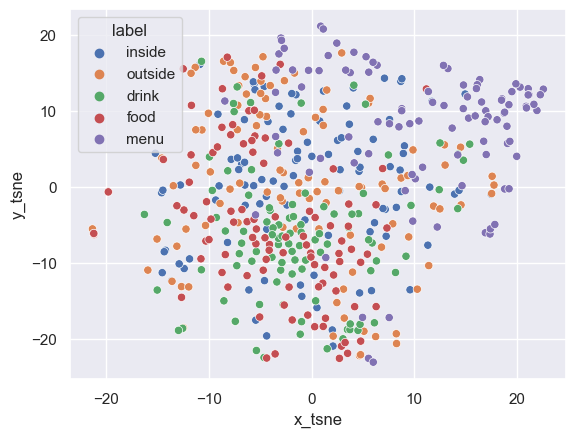

Clustering
Affichage des clusters


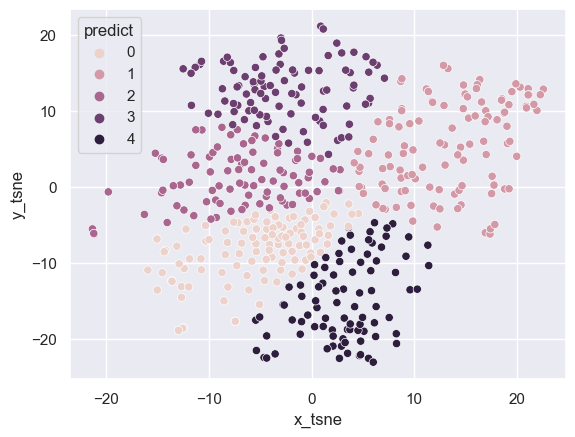

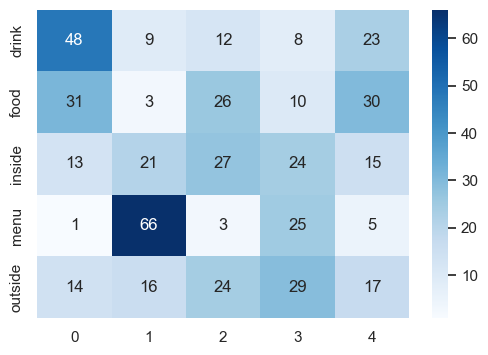

Adjusted rand score = 0.117


In [46]:
pca_tsne_clustering(df=df_sift, x_tsne='x_tsne', y_tsne='y_tsne', predict = 'predict')

## Clustering par CNN

In [47]:
df_cnn = df_photos_sampling.copy()

### Pretraitement des images

In [48]:
(width_max, height_max) = (int(df_cnn['width'].max()), int(df_cnn['height'].max()))

In [49]:
from PIL import Image, ImageOps

def preprocess_images_cnn(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_cnn(photo_id)

def preprocess_image_cnn(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        print(f'Taille originale => Hauteur: {img.height}, Largeur: {img.width}')
    else:
        img = Image.open(original_path)

    border_width_1 = (width_max - img.width) // 2
    border_width_2 = width_max - img.width - border_width_1
    
    border_height_1 = (height_max - img.height) // 2
    border_height_2 = height_max - img.height - border_height_1
    
    img = ImageOps.expand(img,border=(border_width_1, border_height_1, border_width_2, border_height_2),fill='black')
    
    new_path = save_img(current_path=original_path, img=img, work_part='cnn')

    if display_evo:
        img = display_img(new_path)
        print(f'Taille ajustée => Hauteur: {img.height}, Largeur: {img.width}')
    
    return new_path

### Exemple de pré-traitement

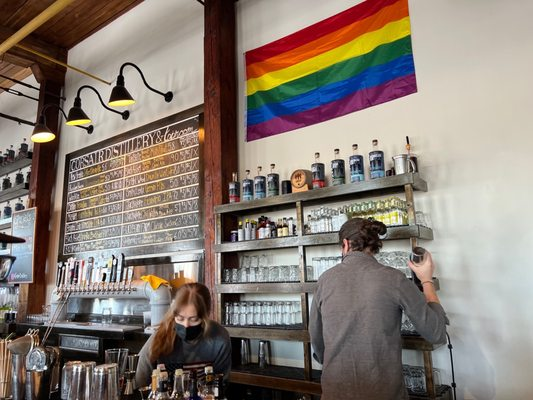

Taille originale => Hauteur: 400, Largeur: 533


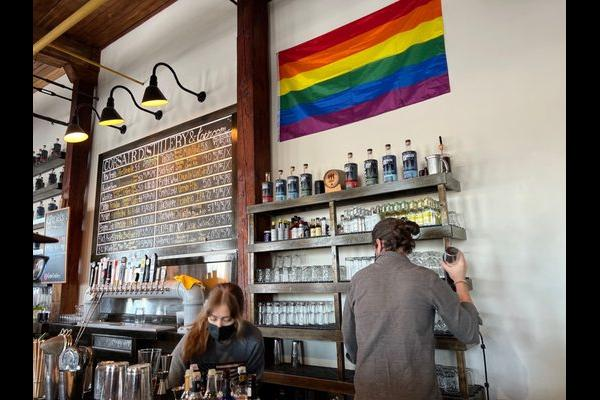

Taille ajustée => Hauteur: 400, Largeur: 600


'data/work/yelp_photos/cnn/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [50]:
preprocess_image_cnn(photo_id=photo_id_sample, display_evo=True)

### Pré-traitement de l'ensemble de l'échantillon

In [51]:
if PREPROCESS_IMAGES:
    preprocess_images_cnn(df=df_cnn)

### Creation des features depuis cnn VGG16

In [52]:
from keras.applications.vgg16 import VGG16
from keras import Input
input = Input(shape=(height_max, width_max, 3))
model = VGG16(include_top=False,input_tensor=input, weights='imagenet', pooling='max')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 300, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 150, 128)     0     

In [53]:
import keras
def features_cnn(photo_id, model, work_dir = WORK_PHOTOS_DIR):
    img_path = work_dir + 'cnn/' + photo_id + '.jpg'
    img = keras.utils.load_img(img_path)
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    features = model.predict(x)
    
    return features[0, :]

In [54]:
df_cnn_parquet = WORK_PHOTOS_DIR + 'df_cnn.parquet'
if EXTRACT_CNN_FEATURES:
    features = df_cnn['photo_id'].apply(features_cnn, args=(model,))
    df_cnn['features'] = features
    df_cnn.to_parquet(df_cnn_parquet)
    df_cnn.sample(3)
else:
    df_cnn = pd.read_parquet(df_cnn_parquet)

1/1 [==============================] - 2s 2s/step


In [55]:
df_cnn

photo_id   label  width  height mode  label_num  \
0    4bCgKE0Itp0T8wQXpYsypg  inside  458.0   400.0  RGB          2   
1    RN1AVvw1HXLceaNJkI0GdQ  inside  300.0   400.0  RGB          2   
2    XDVvq4N-wZV5jKVSUYXI2Q  inside  300.0   400.0  RGB          2   
3    IBCtJNh1XJApQSCSzLznlw  inside  533.0   400.0  RGB          2   
4    XIiiz9u9TY5CWjWlUW4pOg  inside  533.0   400.0  RGB          2   
..                      ...     ...    ...     ...  ...        ...   
495  jxxdyVxLYxoAZx_u0Nk15Q    menu  508.0   400.0  RGB          3   
496  gOZd2DVI9UJ7H2P3tl3L0w    menu  259.0   400.0  RGB          3   
497  CmXqOedu60VEv5DNP-uOUQ    menu  266.0   400.0  RGB          3   
498  yS8ClmejCknInl9qOCtyVQ    menu  300.0   400.0  RGB          3   
499  x4acVHke3X7o6hrVaulmQA    menu  533.0   400.0  RGB          3   

                                              features  
0    [35.223938, 33.700714, 25.606846, 12.462732, 3...  
1    [70.471504, 36.027496, 12.217644, 0.0, 39.1215...  
2    [3.337722, 3.944926, 0.0, 28.995647, 50.51716,...  
3    [47.97095, 31.787832, 21.953213, 19.160604, 31...  
4    [0.0, 62.49377, 28.536158, 76.32431, 79.88773,...  
..                                                 ...  
495  [107.864784, 62.931076, 60.272526, 18.55579, 3...  
496  [0.0, 23.82003, 0.0, 0.0, 0.82622176, 0.0, 0.0...  
497  [3.0549839, 67.44239, 6.790692, 0.0, 4.5489073...  
498  [0.0, 0.0, 60.300762, 0.0, 11.849302, 3.311071...  
499  [12.708607, 0.0, 0.0, 7.721677, 76.813736, 29....  

[500 rows x 7 columns]

### Test 1: PCA -> TSNE -> KMEAN

Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes
Reduction TSNE en 2 dimensions


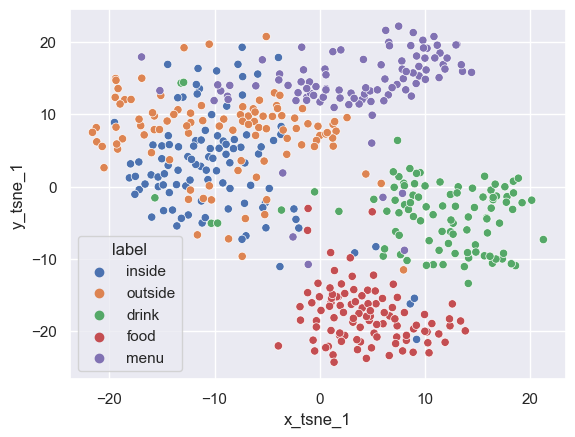

Clustering
Affichage des clusters


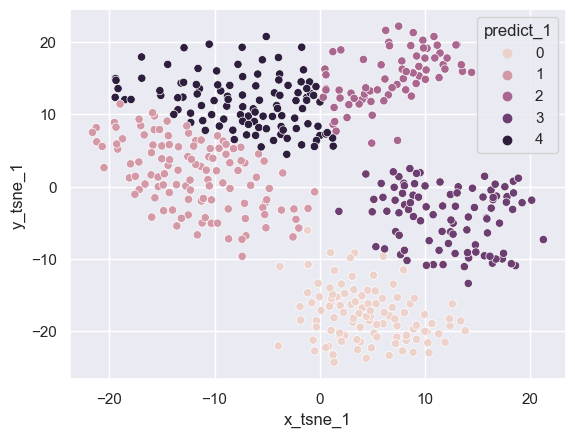

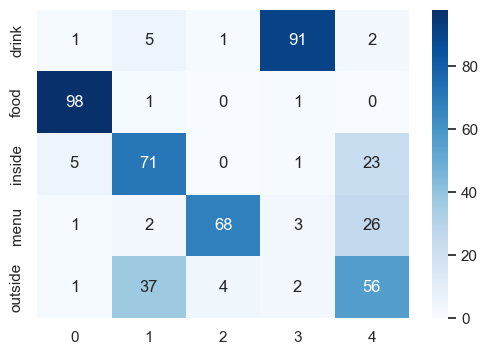

Adjusted rand score = 0.570


In [56]:
pca_tsne_clustering(df=df_cnn, x_tsne='x_tsne_1', y_tsne='y_tsne_1', predict='predict_1')

### Test 2: KMEAN -> PCA -> TSNE

Clustering
Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes
Reduction TSNE en 2 dimensions


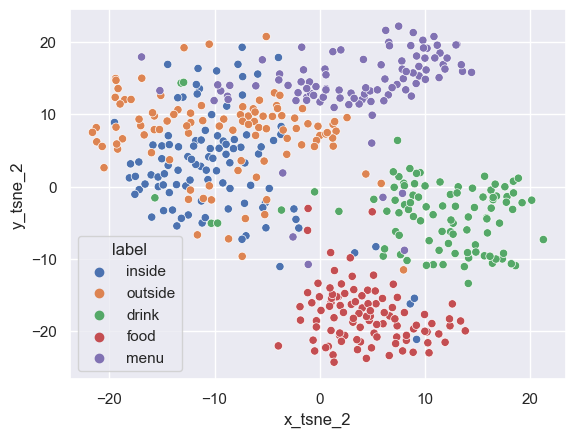

Affichage des clusters


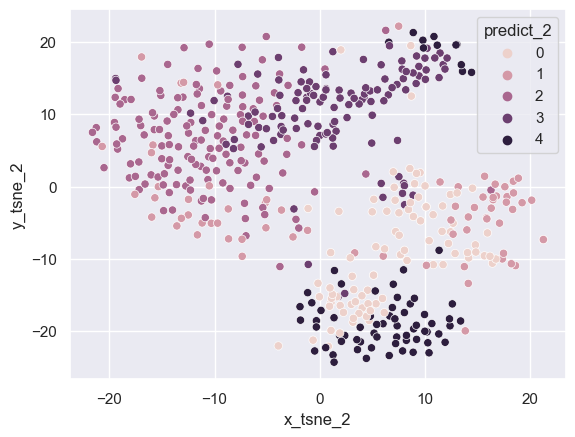

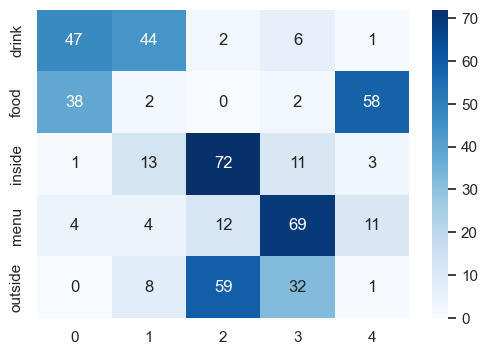

Adjusted rand score = 0.318


In [57]:
clustering_pca_tsne(df=df_cnn, x_tsne='x_tsne_2', y_tsne='y_tsne_2', predict='predict_2')

### Test 3: PCA (50% variance) -> KMEAN -> TSNE

Reduction PCA
En concervant 50.0% de la variance, la PCA réduit les features de 512 composantes à 21 composantes
Clustering
Reduction TSNE en 2 dimensions


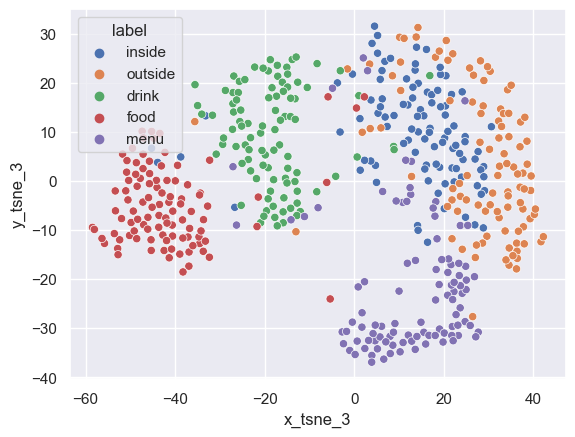

Affichage des clusters


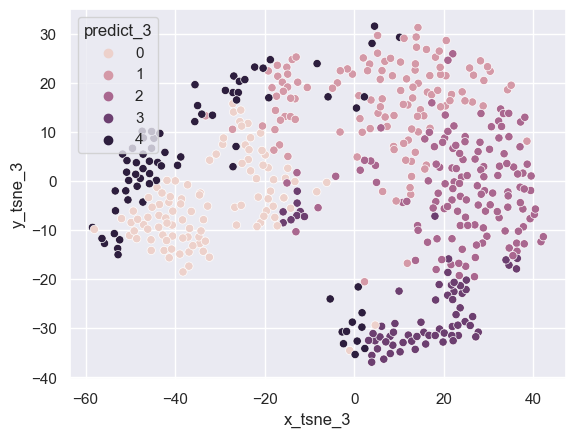

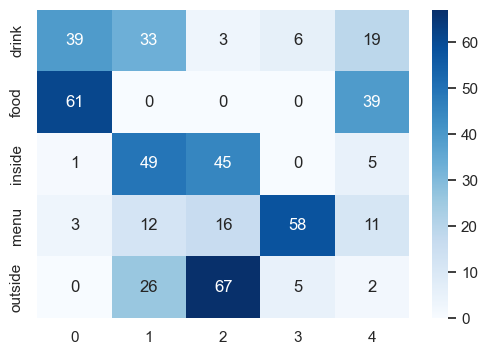

Adjusted rand score = 0.269


In [58]:
pca_clustering_tsne(df=df_cnn, x_tsne='x_tsne_3', y_tsne='y_tsne_3', predict='predict_3', pca_keep_variance=0.5)

# YELP Resquest

In [59]:
def request_yelp(ville: str, nombre_restau: int):
    file_reviews = WORK_DATASET_DIR + 'reviews_request.parquet'
    
    if not REQUEST_YELP:
        print('Read from previous requested (because of daily rate API limits)')
        return pd.read_parquet(file_reviews)

    try:
        authorization = f'Bearer {YELP_API_KEY}'
        headers = {
            'Authorization': authorization,
            'accept': 'application/json'
        }
        
        # GET Business Ids
        print('search request yelp in progress')
        nombre_restau = min(nombre_restau, 200)
        limit = min(nombre_restau, 50)
        df_businesses = pd.DataFrame()
        url = 'https://api.yelp.com/v3/businesses/search'
        params={
            'location': ville,
            'categories': 'Restaurant',
            'sort_by': 'best_match',
            'limit': str(limit),
            'offset': '0'
        }
        for offset in range(0, nombre_restau, limit):
            params['offset'] = str(offset)
            response_businesses = requests.get(url=url, params=params, headers=headers)
            new_records = pd.DataFrame.from_records(response_businesses.json()['businesses'])
            df_businesses = pd.concat([df_businesses, new_records], ignore_index=True)
        
        # Get Reviews
        businesses_id = list(df_businesses['id'])
        params={
            'limit': '50', # Free account limit to 3 reviews per id...
            'offset': '0'
        }
        df_reviews = pd.DataFrame()
        for id in businesses_id:
            url = f'https://api.yelp.com/v3/businesses/{id}/reviews'
            response_reviews = requests.get(url=url, params=params, headers=headers)
            new_records = pd.DataFrame.from_records(response_reviews.json()['reviews'])
            df_reviews = pd.concat([df_reviews, new_records], ignore_index=True) 

        
        df_reviews = df_reviews.loc[:, ['text', 'rating']]
        df_reviews.to_parquet(file_reviews, engine='fastparquet')
        
        print('Succès!')
        return df_reviews
        
    except Exception as err:
        print(f'Une erreur est renvoyée: {err}')  

In [60]:
# REQUEST YELP HERE
ville = 'Paris'
nb_restau = 200
df_reviews_request = request_yelp(ville=ville, nombre_restau=nb_restau)

search request yelp in progress
Succès!


In [61]:
print('Extrait des reviews provenant de l\'API YELP')
display(df_reviews_request.sample(5))
print(f'Il y a {df_reviews_request.shape[0]} enregistrements pour {nb_restau} restaurants de la ville de {ville}\n(NB: l\'api YELP ne fournit que 3 reviews par business id en version gratuite)')

Extrait des reviews provenant de l'API YELP


text  rating
132  What an experience!\n\nThe space is small and ...       5
199  Escargot is very good here, they're extra on t...       4
593  Lunch : 4/5 for food, service, value, and ambi...       4
340  Favorite breakfast of the trip. Atmosphere is ...       5
213  What an excellent little restaurant.  We had t...       5

Il y a 600 enregistrements pour 200 restaurants de la ville de Paris
(NB: l'api YELP ne fournit que 3 reviews par business id en version gratuite)
